In [1]:
import numpy as np

import gym

from keras.models import Model
from keras.layers import Input, Dense
from keras import backend as K
from keras.optimizers import Adam

# import numba as nb
from tensorboardX import SummaryWriter

Using TensorFlow backend.
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:

ENV = 'Acrobot-v1'
CONTINUOUS = False

EPISODES = 10000

LOSS_CLIPPING = 0.2 # Only implemented clipping for the surrogate loss, paper said it was best
EPOCHS = 10
NOISE = 1.0 # Exploration noise

GAMMA = 0.99

BUFFER_SIZE = 2048
BATCH_SIZE = 256
NUM_ACTIONS = 3 #cartpole=2, acrobot = 3
NUM_STATE = 6 #cartpole =4,acrobot = 6
HIDDEN_SIZE = 128 #Cartpole 128, acrobot 256
NUM_LAYERS = 3 #cartpole = 2, #acrobot = 4
ENTROPY_LOSS = 5e-3
LR = 1e-4  # Lower lr stabilises training greatly

DUMMY_ACTION, DUMMY_VALUE = np.zeros((1, NUM_ACTIONS)), np.zeros((1, 1))

In [3]:
def exponential_average(old, new, b1):
    return old * b1 + (1-b1) * new

In [4]:
def proximal_policy_optimization_loss(advantage, old_prediction):
    def loss(y_true, y_pred):
        prob = K.sum(y_true * y_pred, axis=-1)
        old_prob = K.sum(y_true * old_prediction, axis=-1)
        r = prob/(old_prob + 1e-10)
        return -K.mean(K.minimum(r * advantage, K.clip(r, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantage) + ENTROPY_LOSS * -(prob * K.log(prob + 1e-10)))
    return loss

In [5]:
def proximal_policy_optimization_loss_continuous(advantage, old_prediction):
    def loss(y_true, y_pred):
        var = K.square(NOISE)
        pi = 3.1415926
        denom = K.sqrt(2 * pi * var)
        prob_num = K.exp(- K.square(y_true - y_pred) / (2 * var))
        old_prob_num = K.exp(- K.square(y_true - old_prediction) / (2 * var))

        prob = prob_num/denom
        old_prob = old_prob_num/denom
        r = prob/(old_prob + 1e-10)

        return -K.mean(K.minimum(r * advantage, K.clip(r, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantage))
    return loss

In [6]:
class Agent:
    def __init__(self):
        self.critic = self.build_critic()
        if CONTINUOUS is False:
            self.actor = self.build_actor()
        else:
            self.actor = self.build_actor_continuous()

        self.env = gym.make(ENV)
        print(self.env.action_space, 'action_space', self.env.observation_space, 'observation_space')
        self.episode = 0
        self.observation = self.env.reset()
        self.val = False
        self.reward = []
        self.reward_over_time = []
        self.name = self.get_name()
        self.writer = SummaryWriter(self.name)
        self.gradient_steps = 0
        self.rewards_list = []

    def get_name(self):
        name = 'AllRuns/'
        if CONTINUOUS is True:
            name += 'continous/'
        else:
            name += 'discrete/'
        name += ENV
        return name

    def build_actor(self):
        state_input = Input(shape=(NUM_STATE,))
        advantage = Input(shape=(1,))
        old_prediction = Input(shape=(NUM_ACTIONS,))

        x = Dense(HIDDEN_SIZE, activation='tanh')(state_input)
        for _ in range(NUM_LAYERS - 1):
            x = Dense(HIDDEN_SIZE, activation='tanh')(x)

        out_actions = Dense(NUM_ACTIONS, activation='softmax', name='output')(x)

        model = Model(inputs=[state_input, advantage, old_prediction], outputs=[out_actions])
        model.compile(optimizer=Adam(lr=LR),
                      loss=[proximal_policy_optimization_loss(
                          advantage=advantage,
                          old_prediction=old_prediction)])
        model.summary()

        return model

    def build_actor_continuous(self):
        state_input = Input(shape=(NUM_STATE,))
        advantage = Input(shape=(1,))
        old_prediction = Input(shape=(NUM_ACTIONS,))

        x = Dense(HIDDEN_SIZE, activation='tanh')(state_input)
        for _ in range(NUM_LAYERS - 1):
            x = Dense(HIDDEN_SIZE, activation='tanh')(x)

        out_actions = Dense(NUM_ACTIONS, name='output', activation='tanh')(x)

        model = Model(inputs=[state_input, advantage, old_prediction], outputs=[out_actions])
        model.compile(optimizer=Adam(lr=LR),
                      loss=[proximal_policy_optimization_loss_continuous(
                          advantage=advantage,
                          old_prediction=old_prediction)])
        model.summary()

        return model

    def build_critic(self):

        state_input = Input(shape=(NUM_STATE,))
        x = Dense(HIDDEN_SIZE, activation='tanh')(state_input)
        for _ in range(NUM_LAYERS - 1):
            x = Dense(HIDDEN_SIZE, activation='tanh')(x)

        out_value = Dense(1)(x)

        model = Model(inputs=[state_input], outputs=[out_value])
        model.compile(optimizer=Adam(lr=LR), loss='mse')

        return model

    def reset_env(self):
        self.episode += 1
        if self.episode % 100 == 0:
            self.val = True
        else:
            self.val = False
        self.observation = self.env.reset()
        self.reward = []

    def get_action(self):
        p = self.actor.predict([self.observation.reshape(1, NUM_STATE), DUMMY_VALUE, DUMMY_ACTION])
        if self.val is False:

            action = np.random.choice(NUM_ACTIONS, p=np.nan_to_num(p[0]))
        else:
            action = np.argmax(p[0])
        action_matrix = np.zeros(NUM_ACTIONS)
        action_matrix[action] = 1
        return action, action_matrix, p

    def get_action_continuous(self):
        p = self.actor.predict([self.observation.reshape(1, NUM_STATE), DUMMY_VALUE, DUMMY_ACTION])
        if self.val is False:
            action = action_matrix = p[0] + np.random.normal(loc=0, scale=NOISE, size=p[0].shape)
        else:
            action = action_matrix = p[0]
        return action, action_matrix, p

    def transform_reward(self):
        if self.val is True:
            self.writer.add_scalar('Val episode reward', np.array(self.reward).sum(), self.episode)
            print("Val Reward=",np.sum(self.reward))
        else:
            print("epidode=", self.episode)
            print('Reward=',np.sum(self.reward))
            self.rewards_list.append(np.sum(self.reward))
            self.writer.add_scalar('Episode reward', np.array(self.reward).sum(), self.episode)
        for j in range(len(self.reward) - 2, -1, -1):
            self.reward[j] += self.reward[j + 1] * GAMMA

    def get_batch(self):
        batch = [[], [], [], []]

        tmp_batch = [[], [], []]
        while len(batch[0]) < BUFFER_SIZE:
            if CONTINUOUS is False:
                action, action_matrix, predicted_action = self.get_action()
            else:
                action, action_matrix, predicted_action = self.get_action_continuous()
            observation, reward, done, info = self.env.step(action)
            self.reward.append(reward)

            tmp_batch[0].append(self.observation)
            tmp_batch[1].append(action_matrix)
            tmp_batch[2].append(predicted_action)
            self.observation = observation

            if done:
                self.transform_reward()
                if self.val is False:
                    for i in range(len(tmp_batch[0])):
                        obs, action, pred = tmp_batch[0][i], tmp_batch[1][i], tmp_batch[2][i]
                        r = self.reward[i]
                        batch[0].append(obs)
                        batch[1].append(action)
                        batch[2].append(pred)
                        batch[3].append(r)
                tmp_batch = [[], [], []]
                self.reset_env()

        obs, action, pred, reward = np.array(batch[0]), np.array(batch[1]), np.array(batch[2]), np.reshape(np.array(batch[3]), (len(batch[3]), 1))
        pred = np.reshape(pred, (pred.shape[0], pred.shape[2]))
        return obs, action, pred, reward

    def run(self):
        rewards_list = []
        while self.episode < EPISODES:
            obs, action, pred, reward = self.get_batch()
            obs, action, pred, reward = obs[:BUFFER_SIZE], action[:BUFFER_SIZE], pred[:BUFFER_SIZE], reward[:BUFFER_SIZE]
            old_prediction = pred
            pred_values = self.critic.predict(obs)
#             print(self.episode)
#             print(np.max(reward))
            rewards_list.append(np.max(reward))
            advantage = reward - pred_values

            actor_loss = self.actor.fit([obs, advantage, old_prediction], [action], batch_size=BATCH_SIZE, shuffle=True, epochs=EPOCHS, verbose=False)
            critic_loss = self.critic.fit([obs], [reward], batch_size=BATCH_SIZE, shuffle=True, epochs=EPOCHS, verbose=False)
            self.writer.add_scalar('Actor loss', actor_loss.history['loss'][-1], self.gradient_steps)
            self.writer.add_scalar('Critic loss', critic_loss.history['loss'][-1], self.gradient_steps)

            self.gradient_steps += 1
        return self.rewards_list

In [7]:
ag = Agent()
rewards = ag.run()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 3)                 387       
Total params: 34,307
Trainable params: 34,307
Non-trainable params: 0
_________________________________________________________________
Discrete(3) action_space Box(6,) observation_space

epidode= 0
Reward= -500.0
epidode= 1
Reward= -500.0
epidode= 2
Reward

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epidode= 5
Reward= -500.0
epidode= 6
Reward= -500.0
epidode= 7
Reward= -500.0
epidode= 8
Reward= -500.0
epidode= 9
Reward= -500.0
epidode= 10
Reward= -500.0
epidode= 11
Reward= -500.0
epidode= 12
Reward= -500.0
epidode= 13
Reward= -500.0
epidode= 14
Reward= -500.0
epidode= 15
Reward= -500.0
epidode= 16
Reward= -500.0
epidode= 17
Reward= -500.0
epidode= 18
Reward= -500.0
epidode= 19
Reward= -500.0
epidode= 20
Reward= -500.0
epidode= 21
Reward= -500.0
epidode= 22
Reward= -500.0
epidode= 23
Reward= -500.0
epidode= 24
Reward= -500.0
epidode= 25
Reward= -493.0
epidode= 26
Reward= -500.0
epidode= 27
Reward= -500.0
epidode= 28
Reward= -500.0
epidode= 29
Reward= -500.0
epidode= 30
Reward= -500.0
epidode= 31
Reward= -500.0
epidode= 32
Reward= -500.0
epidode= 33
Reward= -500.0
epidode= 34
Reward= -500.0
epidode= 35
Reward= -500.0
epidode= 36
Reward= -500.0
epidode= 37
Reward= -500.0
epidode= 38
Reward= -500.0
epidode= 39
Reward= -500.0
epidode= 40
Reward= -500.0
epidode= 41
Reward= -363.0
epidod

epidode= 303
Reward= -338.0
epidode= 304
Reward= -268.0
epidode= 305
Reward= -303.0
epidode= 306
Reward= -500.0
epidode= 307
Reward= -275.0
epidode= 308
Reward= -404.0
epidode= 309
Reward= -393.0
epidode= 310
Reward= -295.0
epidode= 311
Reward= -208.0
epidode= 312
Reward= -227.0
epidode= 313
Reward= -271.0
epidode= 314
Reward= -231.0
epidode= 315
Reward= -227.0
epidode= 316
Reward= -208.0
epidode= 317
Reward= -157.0
epidode= 318
Reward= -225.0
epidode= 319
Reward= -134.0
epidode= 320
Reward= -304.0
epidode= 321
Reward= -260.0
epidode= 322
Reward= -172.0
epidode= 323
Reward= -302.0
epidode= 324
Reward= -356.0
epidode= 325
Reward= -500.0
epidode= 326
Reward= -199.0
epidode= 327
Reward= -257.0
epidode= 328
Reward= -215.0
epidode= 329
Reward= -247.0
epidode= 330
Reward= -173.0
epidode= 331
Reward= -172.0
epidode= 332
Reward= -187.0
epidode= 333
Reward= -195.0
epidode= 334
Reward= -244.0
epidode= 335
Reward= -162.0
epidode= 336
Reward= -207.0
epidode= 337
Reward= -250.0
epidode= 338
Reward=

epidode= 598
Reward= -203.0
epidode= 599
Reward= -164.0
Val Reward= -187.0
epidode= 601
Reward= -196.0
epidode= 602
Reward= -324.0
epidode= 603
Reward= -178.0
epidode= 604
Reward= -213.0
epidode= 605
Reward= -205.0
epidode= 606
Reward= -242.0
epidode= 607
Reward= -198.0
epidode= 608
Reward= -223.0
epidode= 609
Reward= -209.0
epidode= 610
Reward= -250.0
epidode= 611
Reward= -210.0
epidode= 612
Reward= -144.0
epidode= 613
Reward= -173.0
epidode= 614
Reward= -249.0
epidode= 615
Reward= -212.0
epidode= 616
Reward= -192.0
epidode= 617
Reward= -167.0
epidode= 618
Reward= -272.0
epidode= 619
Reward= -290.0
epidode= 620
Reward= -195.0
epidode= 621
Reward= -248.0
epidode= 622
Reward= -354.0
epidode= 623
Reward= -308.0
epidode= 624
Reward= -378.0
epidode= 625
Reward= -221.0
epidode= 626
Reward= -232.0
epidode= 627
Reward= -229.0
epidode= 628
Reward= -500.0
epidode= 629
Reward= -258.0
epidode= 630
Reward= -178.0
epidode= 631
Reward= -214.0
epidode= 632
Reward= -243.0
epidode= 633
Reward= -186.0
e

epidode= 892
Reward= -195.0
epidode= 893
Reward= -215.0
epidode= 894
Reward= -194.0
epidode= 895
Reward= -170.0
epidode= 896
Reward= -172.0
epidode= 897
Reward= -150.0
epidode= 898
Reward= -152.0
epidode= 899
Reward= -154.0
Val Reward= -281.0
epidode= 901
Reward= -151.0
epidode= 902
Reward= -206.0
epidode= 903
Reward= -233.0
epidode= 904
Reward= -424.0
epidode= 905
Reward= -203.0
epidode= 906
Reward= -139.0
epidode= 907
Reward= -125.0
epidode= 908
Reward= -208.0
epidode= 909
Reward= -241.0
epidode= 910
Reward= -167.0
epidode= 911
Reward= -222.0
epidode= 912
Reward= -230.0
epidode= 913
Reward= -152.0
epidode= 914
Reward= -291.0
epidode= 915
Reward= -238.0
epidode= 916
Reward= -198.0
epidode= 917
Reward= -242.0
epidode= 918
Reward= -231.0
epidode= 919
Reward= -213.0
epidode= 920
Reward= -155.0
epidode= 921
Reward= -208.0
epidode= 922
Reward= -188.0
epidode= 923
Reward= -177.0
epidode= 924
Reward= -236.0
epidode= 925
Reward= -191.0
epidode= 926
Reward= -195.0
epidode= 927
Reward= -200.0
e

epidode= 1180
Reward= -407.0
epidode= 1181
Reward= -372.0
epidode= 1182
Reward= -240.0
epidode= 1183
Reward= -470.0
epidode= 1184
Reward= -287.0
epidode= 1185
Reward= -190.0
epidode= 1186
Reward= -212.0
epidode= 1187
Reward= -315.0
epidode= 1188
Reward= -229.0
epidode= 1189
Reward= -415.0
epidode= 1190
Reward= -268.0
epidode= 1191
Reward= -360.0
epidode= 1192
Reward= -500.0
epidode= 1193
Reward= -227.0
epidode= 1194
Reward= -186.0
epidode= 1195
Reward= -230.0
epidode= 1196
Reward= -227.0
epidode= 1197
Reward= -330.0
epidode= 1198
Reward= -198.0
epidode= 1199
Reward= -156.0
Val Reward= -500.0
epidode= 1201
Reward= -291.0
epidode= 1202
Reward= -304.0
epidode= 1203
Reward= -235.0
epidode= 1204
Reward= -299.0
epidode= 1205
Reward= -230.0
epidode= 1206
Reward= -193.0
epidode= 1207
Reward= -317.0
epidode= 1208
Reward= -465.0
epidode= 1209
Reward= -281.0
epidode= 1210
Reward= -211.0
epidode= 1211
Reward= -181.0
epidode= 1212
Reward= -143.0
epidode= 1213
Reward= -271.0
epidode= 1214
Reward= -2

epidode= 1464
Reward= -197.0
epidode= 1465
Reward= -145.0
epidode= 1466
Reward= -165.0
epidode= 1467
Reward= -171.0
epidode= 1468
Reward= -208.0
epidode= 1469
Reward= -151.0
epidode= 1470
Reward= -156.0
epidode= 1471
Reward= -154.0
epidode= 1472
Reward= -161.0
epidode= 1473
Reward= -199.0
epidode= 1474
Reward= -144.0
epidode= 1475
Reward= -209.0
epidode= 1476
Reward= -157.0
epidode= 1477
Reward= -190.0
epidode= 1478
Reward= -191.0
epidode= 1479
Reward= -132.0
epidode= 1480
Reward= -148.0
epidode= 1481
Reward= -168.0
epidode= 1482
Reward= -188.0
epidode= 1483
Reward= -221.0
epidode= 1484
Reward= -180.0
epidode= 1485
Reward= -152.0
epidode= 1486
Reward= -140.0
epidode= 1487
Reward= -169.0
epidode= 1488
Reward= -151.0
epidode= 1489
Reward= -180.0
epidode= 1490
Reward= -177.0
epidode= 1491
Reward= -132.0
epidode= 1492
Reward= -123.0
epidode= 1493
Reward= -194.0
epidode= 1494
Reward= -165.0
epidode= 1495
Reward= -139.0
epidode= 1496
Reward= -158.0
epidode= 1497
Reward= -193.0
epidode= 1498


epidode= 1749
Reward= -167.0
epidode= 1750
Reward= -191.0
epidode= 1751
Reward= -208.0
epidode= 1752
Reward= -121.0
epidode= 1753
Reward= -183.0
epidode= 1754
Reward= -201.0
epidode= 1755
Reward= -211.0
epidode= 1756
Reward= -167.0
epidode= 1757
Reward= -168.0
epidode= 1758
Reward= -201.0
epidode= 1759
Reward= -169.0
epidode= 1760
Reward= -140.0
epidode= 1761
Reward= -171.0
epidode= 1762
Reward= -201.0
epidode= 1763
Reward= -157.0
epidode= 1764
Reward= -222.0
epidode= 1765
Reward= -148.0
epidode= 1766
Reward= -239.0
epidode= 1767
Reward= -500.0
epidode= 1768
Reward= -207.0
epidode= 1769
Reward= -171.0
epidode= 1770
Reward= -178.0
epidode= 1771
Reward= -252.0
epidode= 1772
Reward= -211.0
epidode= 1773
Reward= -156.0
epidode= 1774
Reward= -167.0
epidode= 1775
Reward= -238.0
epidode= 1776
Reward= -195.0
epidode= 1777
Reward= -137.0
epidode= 1778
Reward= -141.0
epidode= 1779
Reward= -216.0
epidode= 1780
Reward= -386.0
epidode= 1781
Reward= -150.0
epidode= 1782
Reward= -239.0
epidode= 1783


epidode= 2034
Reward= -212.0
epidode= 2035
Reward= -277.0
epidode= 2036
Reward= -207.0
epidode= 2037
Reward= -299.0
epidode= 2038
Reward= -252.0
epidode= 2039
Reward= -169.0
epidode= 2040
Reward= -244.0
epidode= 2041
Reward= -273.0
epidode= 2042
Reward= -179.0
epidode= 2043
Reward= -153.0
epidode= 2044
Reward= -160.0
epidode= 2045
Reward= -192.0
epidode= 2046
Reward= -255.0
epidode= 2047
Reward= -183.0
epidode= 2048
Reward= -231.0
epidode= 2049
Reward= -211.0
epidode= 2050
Reward= -222.0
epidode= 2051
Reward= -205.0
epidode= 2052
Reward= -220.0
epidode= 2053
Reward= -131.0
epidode= 2054
Reward= -218.0
epidode= 2055
Reward= -150.0
epidode= 2056
Reward= -358.0
epidode= 2057
Reward= -176.0
epidode= 2058
Reward= -191.0
epidode= 2059
Reward= -263.0
epidode= 2060
Reward= -214.0
epidode= 2061
Reward= -191.0
epidode= 2062
Reward= -195.0
epidode= 2063
Reward= -186.0
epidode= 2064
Reward= -294.0
epidode= 2065
Reward= -184.0
epidode= 2066
Reward= -286.0
epidode= 2067
Reward= -169.0
epidode= 2068


epidode= 2319
Reward= -196.0
epidode= 2320
Reward= -142.0
epidode= 2321
Reward= -159.0
epidode= 2322
Reward= -157.0
epidode= 2323
Reward= -202.0
epidode= 2324
Reward= -147.0
epidode= 2325
Reward= -232.0
epidode= 2326
Reward= -164.0
epidode= 2327
Reward= -155.0
epidode= 2328
Reward= -176.0
epidode= 2329
Reward= -200.0
epidode= 2330
Reward= -232.0
epidode= 2331
Reward= -190.0
epidode= 2332
Reward= -214.0
epidode= 2333
Reward= -233.0
epidode= 2334
Reward= -168.0
epidode= 2335
Reward= -144.0
epidode= 2336
Reward= -185.0
epidode= 2337
Reward= -136.0
epidode= 2338
Reward= -155.0
epidode= 2339
Reward= -244.0
epidode= 2340
Reward= -150.0
epidode= 2341
Reward= -182.0
epidode= 2342
Reward= -152.0
epidode= 2343
Reward= -163.0
epidode= 2344
Reward= -149.0
epidode= 2345
Reward= -205.0
epidode= 2346
Reward= -500.0
epidode= 2347
Reward= -170.0
epidode= 2348
Reward= -135.0
epidode= 2349
Reward= -185.0
epidode= 2350
Reward= -152.0
epidode= 2351
Reward= -207.0
epidode= 2352
Reward= -207.0
epidode= 2353


epidode= 2604
Reward= -170.0
epidode= 2605
Reward= -161.0
epidode= 2606
Reward= -259.0
epidode= 2607
Reward= -188.0
epidode= 2608
Reward= -205.0
epidode= 2609
Reward= -215.0
epidode= 2610
Reward= -185.0
epidode= 2611
Reward= -153.0
epidode= 2612
Reward= -179.0
epidode= 2613
Reward= -216.0
epidode= 2614
Reward= -142.0
epidode= 2615
Reward= -161.0
epidode= 2616
Reward= -218.0
epidode= 2617
Reward= -158.0
epidode= 2618
Reward= -226.0
epidode= 2619
Reward= -236.0
epidode= 2620
Reward= -205.0
epidode= 2621
Reward= -202.0
epidode= 2622
Reward= -184.0
epidode= 2623
Reward= -164.0
epidode= 2624
Reward= -179.0
epidode= 2625
Reward= -184.0
epidode= 2626
Reward= -248.0
epidode= 2627
Reward= -164.0
epidode= 2628
Reward= -155.0
epidode= 2629
Reward= -210.0
epidode= 2630
Reward= -376.0
epidode= 2631
Reward= -142.0
epidode= 2632
Reward= -145.0
epidode= 2633
Reward= -183.0
epidode= 2634
Reward= -160.0
epidode= 2635
Reward= -152.0
epidode= 2636
Reward= -168.0
epidode= 2637
Reward= -136.0
epidode= 2638


epidode= 2888
Reward= -191.0
epidode= 2889
Reward= -201.0
epidode= 2890
Reward= -179.0
epidode= 2891
Reward= -234.0
epidode= 2892
Reward= -287.0
epidode= 2893
Reward= -253.0
epidode= 2894
Reward= -141.0
epidode= 2895
Reward= -207.0
epidode= 2896
Reward= -154.0
epidode= 2897
Reward= -153.0
epidode= 2898
Reward= -161.0
epidode= 2899
Reward= -155.0
Val Reward= -500.0
epidode= 2901
Reward= -225.0
epidode= 2902
Reward= -160.0
epidode= 2903
Reward= -179.0
epidode= 2904
Reward= -198.0
epidode= 2905
Reward= -185.0
epidode= 2906
Reward= -166.0
epidode= 2907
Reward= -198.0
epidode= 2908
Reward= -227.0
epidode= 2909
Reward= -185.0
epidode= 2910
Reward= -178.0
epidode= 2911
Reward= -132.0
epidode= 2912
Reward= -204.0
epidode= 2913
Reward= -200.0
epidode= 2914
Reward= -168.0
epidode= 2915
Reward= -210.0
epidode= 2916
Reward= -177.0
epidode= 2917
Reward= -172.0
epidode= 2918
Reward= -144.0
epidode= 2919
Reward= -176.0
epidode= 2920
Reward= -461.0
epidode= 2921
Reward= -193.0
epidode= 2922
Reward= -1

epidode= 3173
Reward= -174.0
epidode= 3174
Reward= -132.0
epidode= 3175
Reward= -150.0
epidode= 3176
Reward= -144.0
epidode= 3177
Reward= -152.0
epidode= 3178
Reward= -194.0
epidode= 3179
Reward= -160.0
epidode= 3180
Reward= -165.0
epidode= 3181
Reward= -155.0
epidode= 3182
Reward= -267.0
epidode= 3183
Reward= -161.0
epidode= 3184
Reward= -140.0
epidode= 3185
Reward= -206.0
epidode= 3186
Reward= -185.0
epidode= 3187
Reward= -250.0
epidode= 3188
Reward= -172.0
epidode= 3189
Reward= -218.0
epidode= 3190
Reward= -218.0
epidode= 3191
Reward= -153.0
epidode= 3192
Reward= -153.0
epidode= 3193
Reward= -248.0
epidode= 3194
Reward= -237.0
epidode= 3195
Reward= -142.0
epidode= 3196
Reward= -202.0
epidode= 3197
Reward= -196.0
epidode= 3198
Reward= -337.0
epidode= 3199
Reward= -211.0
Val Reward= -500.0
epidode= 3201
Reward= -246.0
epidode= 3202
Reward= -222.0
epidode= 3203
Reward= -219.0
epidode= 3204
Reward= -132.0
epidode= 3205
Reward= -222.0
epidode= 3206
Reward= -174.0
epidode= 3207
Reward= -1

epidode= 3457
Reward= -257.0
epidode= 3458
Reward= -141.0
epidode= 3459
Reward= -210.0
epidode= 3460
Reward= -194.0
epidode= 3461
Reward= -188.0
epidode= 3462
Reward= -242.0
epidode= 3463
Reward= -159.0
epidode= 3464
Reward= -116.0
epidode= 3465
Reward= -284.0
epidode= 3466
Reward= -208.0
epidode= 3467
Reward= -245.0
epidode= 3468
Reward= -191.0
epidode= 3469
Reward= -178.0
epidode= 3470
Reward= -173.0
epidode= 3471
Reward= -145.0
epidode= 3472
Reward= -211.0
epidode= 3473
Reward= -185.0
epidode= 3474
Reward= -175.0
epidode= 3475
Reward= -178.0
epidode= 3476
Reward= -141.0
epidode= 3477
Reward= -141.0
epidode= 3478
Reward= -195.0
epidode= 3479
Reward= -235.0
epidode= 3480
Reward= -206.0
epidode= 3481
Reward= -194.0
epidode= 3482
Reward= -234.0
epidode= 3483
Reward= -200.0
epidode= 3484
Reward= -230.0
epidode= 3485
Reward= -242.0
epidode= 3486
Reward= -189.0
epidode= 3487
Reward= -205.0
epidode= 3488
Reward= -178.0
epidode= 3489
Reward= -165.0
epidode= 3490
Reward= -228.0
epidode= 3491


epidode= 3741
Reward= -185.0
epidode= 3742
Reward= -157.0
epidode= 3743
Reward= -231.0
epidode= 3744
Reward= -151.0
epidode= 3745
Reward= -158.0
epidode= 3746
Reward= -187.0
epidode= 3747
Reward= -170.0
epidode= 3748
Reward= -177.0
epidode= 3749
Reward= -238.0
epidode= 3750
Reward= -144.0
epidode= 3751
Reward= -195.0
epidode= 3752
Reward= -289.0
epidode= 3753
Reward= -145.0
epidode= 3754
Reward= -167.0
epidode= 3755
Reward= -176.0
epidode= 3756
Reward= -238.0
epidode= 3757
Reward= -163.0
epidode= 3758
Reward= -147.0
epidode= 3759
Reward= -158.0
epidode= 3760
Reward= -219.0
epidode= 3761
Reward= -163.0
epidode= 3762
Reward= -144.0
epidode= 3763
Reward= -234.0
epidode= 3764
Reward= -146.0
epidode= 3765
Reward= -181.0
epidode= 3766
Reward= -190.0
epidode= 3767
Reward= -261.0
epidode= 3768
Reward= -178.0
epidode= 3769
Reward= -189.0
epidode= 3770
Reward= -225.0
epidode= 3771
Reward= -168.0
epidode= 3772
Reward= -156.0
epidode= 3773
Reward= -152.0
epidode= 3774
Reward= -215.0
epidode= 3775


epidode= 4025
Reward= -175.0
epidode= 4026
Reward= -132.0
epidode= 4027
Reward= -188.0
epidode= 4028
Reward= -141.0
epidode= 4029
Reward= -172.0
epidode= 4030
Reward= -165.0
epidode= 4031
Reward= -163.0
epidode= 4032
Reward= -202.0
epidode= 4033
Reward= -143.0
epidode= 4034
Reward= -131.0
epidode= 4035
Reward= -163.0
epidode= 4036
Reward= -155.0
epidode= 4037
Reward= -205.0
epidode= 4038
Reward= -164.0
epidode= 4039
Reward= -164.0
epidode= 4040
Reward= -198.0
epidode= 4041
Reward= -145.0
epidode= 4042
Reward= -187.0
epidode= 4043
Reward= -170.0
epidode= 4044
Reward= -199.0
epidode= 4045
Reward= -163.0
epidode= 4046
Reward= -147.0
epidode= 4047
Reward= -191.0
epidode= 4048
Reward= -149.0
epidode= 4049
Reward= -137.0
epidode= 4050
Reward= -146.0
epidode= 4051
Reward= -145.0
epidode= 4052
Reward= -169.0
epidode= 4053
Reward= -206.0
epidode= 4054
Reward= -159.0
epidode= 4055
Reward= -156.0
epidode= 4056
Reward= -158.0
epidode= 4057
Reward= -146.0
epidode= 4058
Reward= -150.0
epidode= 4059


epidode= 4309
Reward= -251.0
epidode= 4310
Reward= -198.0
epidode= 4311
Reward= -176.0
epidode= 4312
Reward= -146.0
epidode= 4313
Reward= -181.0
epidode= 4314
Reward= -164.0
epidode= 4315
Reward= -155.0
epidode= 4316
Reward= -163.0
epidode= 4317
Reward= -170.0
epidode= 4318
Reward= -224.0
epidode= 4319
Reward= -157.0
epidode= 4320
Reward= -140.0
epidode= 4321
Reward= -156.0
epidode= 4322
Reward= -132.0
epidode= 4323
Reward= -196.0
epidode= 4324
Reward= -209.0
epidode= 4325
Reward= -284.0
epidode= 4326
Reward= -174.0
epidode= 4327
Reward= -186.0
epidode= 4328
Reward= -187.0
epidode= 4329
Reward= -140.0
epidode= 4330
Reward= -158.0
epidode= 4331
Reward= -158.0
epidode= 4332
Reward= -141.0
epidode= 4333
Reward= -219.0
epidode= 4334
Reward= -146.0
epidode= 4335
Reward= -178.0
epidode= 4336
Reward= -242.0
epidode= 4337
Reward= -163.0
epidode= 4338
Reward= -176.0
epidode= 4339
Reward= -150.0
epidode= 4340
Reward= -207.0
epidode= 4341
Reward= -186.0
epidode= 4342
Reward= -231.0
epidode= 4343


epidode= 4593
Reward= -140.0
epidode= 4594
Reward= -165.0
epidode= 4595
Reward= -145.0
epidode= 4596
Reward= -131.0
epidode= 4597
Reward= -146.0
epidode= 4598
Reward= -167.0
epidode= 4599
Reward= -167.0
Val Reward= -179.0
epidode= 4601
Reward= -160.0
epidode= 4602
Reward= -177.0
epidode= 4603
Reward= -212.0
epidode= 4604
Reward= -177.0
epidode= 4605
Reward= -146.0
epidode= 4606
Reward= -167.0
epidode= 4607
Reward= -154.0
epidode= 4608
Reward= -203.0
epidode= 4609
Reward= -158.0
epidode= 4610
Reward= -178.0
epidode= 4611
Reward= -161.0
epidode= 4612
Reward= -166.0
epidode= 4613
Reward= -140.0
epidode= 4614
Reward= -165.0
epidode= 4615
Reward= -145.0
epidode= 4616
Reward= -159.0
epidode= 4617
Reward= -313.0
epidode= 4618
Reward= -164.0
epidode= 4619
Reward= -155.0
epidode= 4620
Reward= -168.0
epidode= 4621
Reward= -146.0
epidode= 4622
Reward= -195.0
epidode= 4623
Reward= -191.0
epidode= 4624
Reward= -332.0
epidode= 4625
Reward= -487.0
epidode= 4626
Reward= -155.0
epidode= 4627
Reward= -1

epidode= 4877
Reward= -143.0
epidode= 4878
Reward= -146.0
epidode= 4879
Reward= -150.0
epidode= 4880
Reward= -149.0
epidode= 4881
Reward= -180.0
epidode= 4882
Reward= -147.0
epidode= 4883
Reward= -132.0
epidode= 4884
Reward= -139.0
epidode= 4885
Reward= -139.0
epidode= 4886
Reward= -203.0
epidode= 4887
Reward= -312.0
epidode= 4888
Reward= -169.0
epidode= 4889
Reward= -160.0
epidode= 4890
Reward= -167.0
epidode= 4891
Reward= -147.0
epidode= 4892
Reward= -181.0
epidode= 4893
Reward= -192.0
epidode= 4894
Reward= -151.0
epidode= 4895
Reward= -220.0
epidode= 4896
Reward= -137.0
epidode= 4897
Reward= -205.0
epidode= 4898
Reward= -151.0
epidode= 4899
Reward= -155.0
Val Reward= -149.0
epidode= 4901
Reward= -191.0
epidode= 4902
Reward= -163.0
epidode= 4903
Reward= -135.0
epidode= 4904
Reward= -155.0
epidode= 4905
Reward= -159.0
epidode= 4906
Reward= -180.0
epidode= 4907
Reward= -188.0
epidode= 4908
Reward= -151.0
epidode= 4909
Reward= -142.0
epidode= 4910
Reward= -181.0
epidode= 4911
Reward= -2

epidode= 5161
Reward= -214.0
epidode= 5162
Reward= -118.0
epidode= 5163
Reward= -171.0
epidode= 5164
Reward= -140.0
epidode= 5165
Reward= -162.0
epidode= 5166
Reward= -187.0
epidode= 5167
Reward= -145.0
epidode= 5168
Reward= -195.0
epidode= 5169
Reward= -152.0
epidode= 5170
Reward= -138.0
epidode= 5171
Reward= -142.0
epidode= 5172
Reward= -207.0
epidode= 5173
Reward= -158.0
epidode= 5174
Reward= -181.0
epidode= 5175
Reward= -150.0
epidode= 5176
Reward= -157.0
epidode= 5177
Reward= -165.0
epidode= 5178
Reward= -171.0
epidode= 5179
Reward= -159.0
epidode= 5180
Reward= -131.0
epidode= 5181
Reward= -230.0
epidode= 5182
Reward= -173.0
epidode= 5183
Reward= -165.0
epidode= 5184
Reward= -138.0
epidode= 5185
Reward= -242.0
epidode= 5186
Reward= -195.0
epidode= 5187
Reward= -178.0
epidode= 5188
Reward= -118.0
epidode= 5189
Reward= -257.0
epidode= 5190
Reward= -138.0
epidode= 5191
Reward= -183.0
epidode= 5192
Reward= -164.0
epidode= 5193
Reward= -159.0
epidode= 5194
Reward= -240.0
epidode= 5195


epidode= 5446
Reward= -209.0
epidode= 5447
Reward= -157.0
epidode= 5448
Reward= -160.0
epidode= 5449
Reward= -137.0
epidode= 5450
Reward= -178.0
epidode= 5451
Reward= -249.0
epidode= 5452
Reward= -143.0
epidode= 5453
Reward= -155.0
epidode= 5454
Reward= -136.0
epidode= 5455
Reward= -154.0
epidode= 5456
Reward= -115.0
epidode= 5457
Reward= -137.0
epidode= 5458
Reward= -215.0
epidode= 5459
Reward= -185.0
epidode= 5460
Reward= -133.0
epidode= 5461
Reward= -148.0
epidode= 5462
Reward= -176.0
epidode= 5463
Reward= -195.0
epidode= 5464
Reward= -173.0
epidode= 5465
Reward= -140.0
epidode= 5466
Reward= -195.0
epidode= 5467
Reward= -200.0
epidode= 5468
Reward= -189.0
epidode= 5469
Reward= -313.0
epidode= 5470
Reward= -214.0
epidode= 5471
Reward= -153.0
epidode= 5472
Reward= -158.0
epidode= 5473
Reward= -185.0
epidode= 5474
Reward= -175.0
epidode= 5475
Reward= -153.0
epidode= 5476
Reward= -174.0
epidode= 5477
Reward= -154.0
epidode= 5478
Reward= -180.0
epidode= 5479
Reward= -143.0
epidode= 5480


epidode= 5730
Reward= -138.0
epidode= 5731
Reward= -138.0
epidode= 5732
Reward= -154.0
epidode= 5733
Reward= -391.0
epidode= 5734
Reward= -138.0
epidode= 5735
Reward= -133.0
epidode= 5736
Reward= -178.0
epidode= 5737
Reward= -171.0
epidode= 5738
Reward= -135.0
epidode= 5739
Reward= -117.0
epidode= 5740
Reward= -147.0
epidode= 5741
Reward= -149.0
epidode= 5742
Reward= -143.0
epidode= 5743
Reward= -167.0
epidode= 5744
Reward= -135.0
epidode= 5745
Reward= -158.0
epidode= 5746
Reward= -182.0
epidode= 5747
Reward= -140.0
epidode= 5748
Reward= -153.0
epidode= 5749
Reward= -137.0
epidode= 5750
Reward= -165.0
epidode= 5751
Reward= -143.0
epidode= 5752
Reward= -192.0
epidode= 5753
Reward= -167.0
epidode= 5754
Reward= -128.0
epidode= 5755
Reward= -120.0
epidode= 5756
Reward= -167.0
epidode= 5757
Reward= -141.0
epidode= 5758
Reward= -128.0
epidode= 5759
Reward= -132.0
epidode= 5760
Reward= -126.0
epidode= 5761
Reward= -175.0
epidode= 5762
Reward= -139.0
epidode= 5763
Reward= -118.0
epidode= 5764


epidode= 6014
Reward= -500.0
epidode= 6015
Reward= -133.0
epidode= 6016
Reward= -162.0
epidode= 6017
Reward= -154.0
epidode= 6018
Reward= -114.0
epidode= 6019
Reward= -180.0
epidode= 6020
Reward= -236.0
epidode= 6021
Reward= -148.0
epidode= 6022
Reward= -116.0
epidode= 6023
Reward= -104.0
epidode= 6024
Reward= -144.0
epidode= 6025
Reward= -168.0
epidode= 6026
Reward= -117.0
epidode= 6027
Reward= -145.0
epidode= 6028
Reward= -133.0
epidode= 6029
Reward= -129.0
epidode= 6030
Reward= -104.0
epidode= 6031
Reward= -104.0
epidode= 6032
Reward= -145.0
epidode= 6033
Reward= -200.0
epidode= 6034
Reward= -150.0
epidode= 6035
Reward= -142.0
epidode= 6036
Reward= -130.0
epidode= 6037
Reward= -118.0
epidode= 6038
Reward= -136.0
epidode= 6039
Reward= -135.0
epidode= 6040
Reward= -177.0
epidode= 6041
Reward= -103.0
epidode= 6042
Reward= -129.0
epidode= 6043
Reward= -129.0
epidode= 6044
Reward= -164.0
epidode= 6045
Reward= -139.0
epidode= 6046
Reward= -142.0
epidode= 6047
Reward= -129.0
epidode= 6048


epidode= 6298
Reward= -145.0
epidode= 6299
Reward= -120.0
Val Reward= -166.0
epidode= 6301
Reward= -231.0
epidode= 6302
Reward= -500.0
epidode= 6303
Reward= -120.0
epidode= 6304
Reward= -139.0
epidode= 6305
Reward= -210.0
epidode= 6306
Reward= -126.0
epidode= 6307
Reward= -116.0
epidode= 6308
Reward= -129.0
epidode= 6309
Reward= -150.0
epidode= 6310
Reward= -105.0
epidode= 6311
Reward= -128.0
epidode= 6312
Reward= -198.0
epidode= 6313
Reward= -140.0
epidode= 6314
Reward= -144.0
epidode= 6315
Reward= -209.0
epidode= 6316
Reward= -140.0
epidode= 6317
Reward= -162.0
epidode= 6318
Reward= -177.0
epidode= 6319
Reward= -143.0
epidode= 6320
Reward= -314.0
epidode= 6321
Reward= -104.0
epidode= 6322
Reward= -134.0
epidode= 6323
Reward= -132.0
epidode= 6324
Reward= -160.0
epidode= 6325
Reward= -218.0
epidode= 6326
Reward= -154.0
epidode= 6327
Reward= -124.0
epidode= 6328
Reward= -161.0
epidode= 6329
Reward= -131.0
epidode= 6330
Reward= -129.0
epidode= 6331
Reward= -106.0
epidode= 6332
Reward= -1

epidode= 6583
Reward= -125.0
epidode= 6584
Reward= -116.0
epidode= 6585
Reward= -147.0
epidode= 6586
Reward= -265.0
epidode= 6587
Reward= -125.0
epidode= 6588
Reward= -130.0
epidode= 6589
Reward= -160.0
epidode= 6590
Reward= -140.0
epidode= 6591
Reward= -140.0
epidode= 6592
Reward= -153.0
epidode= 6593
Reward= -104.0
epidode= 6594
Reward= -101.0
epidode= 6595
Reward= -123.0
epidode= 6596
Reward= -225.0
epidode= 6597
Reward= -166.0
epidode= 6598
Reward= -122.0
epidode= 6599
Reward= -116.0
Val Reward= -132.0
epidode= 6601
Reward= -137.0
epidode= 6602
Reward= -188.0
epidode= 6603
Reward= -146.0
epidode= 6604
Reward= -98.0
epidode= 6605
Reward= -129.0
epidode= 6606
Reward= -103.0
epidode= 6607
Reward= -144.0
epidode= 6608
Reward= -116.0
epidode= 6609
Reward= -125.0
epidode= 6610
Reward= -125.0
epidode= 6611
Reward= -135.0
epidode= 6612
Reward= -106.0
epidode= 6613
Reward= -200.0
epidode= 6614
Reward= -183.0
epidode= 6615
Reward= -114.0
epidode= 6616
Reward= -123.0
epidode= 6617
Reward= -22

epidode= 6868
Reward= -147.0
epidode= 6869
Reward= -221.0
epidode= 6870
Reward= -113.0
epidode= 6871
Reward= -125.0
epidode= 6872
Reward= -159.0
epidode= 6873
Reward= -138.0
epidode= 6874
Reward= -148.0
epidode= 6875
Reward= -157.0
epidode= 6876
Reward= -135.0
epidode= 6877
Reward= -106.0
epidode= 6878
Reward= -228.0
epidode= 6879
Reward= -134.0
epidode= 6880
Reward= -103.0
epidode= 6881
Reward= -139.0
epidode= 6882
Reward= -166.0
epidode= 6883
Reward= -150.0
epidode= 6884
Reward= -125.0
epidode= 6885
Reward= -125.0
epidode= 6886
Reward= -134.0
epidode= 6887
Reward= -127.0
epidode= 6888
Reward= -158.0
epidode= 6889
Reward= -128.0
epidode= 6890
Reward= -114.0
epidode= 6891
Reward= -123.0
epidode= 6892
Reward= -135.0
epidode= 6893
Reward= -104.0
epidode= 6894
Reward= -153.0
epidode= 6895
Reward= -185.0
epidode= 6896
Reward= -120.0
epidode= 6897
Reward= -168.0
epidode= 6898
Reward= -124.0
epidode= 6899
Reward= -126.0
Val Reward= -125.0
epidode= 6901
Reward= -169.0
epidode= 6902
Reward= -1

epidode= 7153
Reward= -147.0
epidode= 7154
Reward= -117.0
epidode= 7155
Reward= -121.0
epidode= 7156
Reward= -119.0
epidode= 7157
Reward= -125.0
epidode= 7158
Reward= -120.0
epidode= 7159
Reward= -115.0
epidode= 7160
Reward= -216.0
epidode= 7161
Reward= -105.0
epidode= 7162
Reward= -106.0
epidode= 7163
Reward= -105.0
epidode= 7164
Reward= -159.0
epidode= 7165
Reward= -118.0
epidode= 7166
Reward= -103.0
epidode= 7167
Reward= -126.0
epidode= 7168
Reward= -220.0
epidode= 7169
Reward= -115.0
epidode= 7170
Reward= -144.0
epidode= 7171
Reward= -215.0
epidode= 7172
Reward= -128.0
epidode= 7173
Reward= -161.0
epidode= 7174
Reward= -138.0
epidode= 7175
Reward= -116.0
epidode= 7176
Reward= -118.0
epidode= 7177
Reward= -133.0
epidode= 7178
Reward= -115.0
epidode= 7179
Reward= -114.0
epidode= 7180
Reward= -137.0
epidode= 7181
Reward= -169.0
epidode= 7182
Reward= -233.0
epidode= 7183
Reward= -123.0
epidode= 7184
Reward= -151.0
epidode= 7185
Reward= -110.0
epidode= 7186
Reward= -111.0
epidode= 7187


epidode= 7439
Reward= -155.0
epidode= 7440
Reward= -144.0
epidode= 7441
Reward= -386.0
epidode= 7442
Reward= -141.0
epidode= 7443
Reward= -131.0
epidode= 7444
Reward= -162.0
epidode= 7445
Reward= -144.0
epidode= 7446
Reward= -141.0
epidode= 7447
Reward= -120.0
epidode= 7448
Reward= -115.0
epidode= 7449
Reward= -368.0
epidode= 7450
Reward= -116.0
epidode= 7451
Reward= -161.0
epidode= 7452
Reward= -117.0
epidode= 7453
Reward= -103.0
epidode= 7454
Reward= -144.0
epidode= 7455
Reward= -128.0
epidode= 7456
Reward= -162.0
epidode= 7457
Reward= -103.0
epidode= 7458
Reward= -104.0
epidode= 7459
Reward= -298.0
epidode= 7460
Reward= -120.0
epidode= 7461
Reward= -117.0
epidode= 7462
Reward= -151.0
epidode= 7463
Reward= -251.0
epidode= 7464
Reward= -111.0
epidode= 7465
Reward= -107.0
epidode= 7466
Reward= -104.0
epidode= 7467
Reward= -161.0
epidode= 7468
Reward= -149.0
epidode= 7469
Reward= -134.0
epidode= 7470
Reward= -115.0
epidode= 7471
Reward= -165.0
epidode= 7472
Reward= -154.0
epidode= 7473


epidode= 7723
Reward= -125.0
epidode= 7724
Reward= -175.0
epidode= 7725
Reward= -120.0
epidode= 7726
Reward= -164.0
epidode= 7727
Reward= -138.0
epidode= 7728
Reward= -134.0
epidode= 7729
Reward= -112.0
epidode= 7730
Reward= -117.0
epidode= 7731
Reward= -131.0
epidode= 7732
Reward= -185.0
epidode= 7733
Reward= -156.0
epidode= 7734
Reward= -159.0
epidode= 7735
Reward= -134.0
epidode= 7736
Reward= -133.0
epidode= 7737
Reward= -105.0
epidode= 7738
Reward= -240.0
epidode= 7739
Reward= -126.0
epidode= 7740
Reward= -140.0
epidode= 7741
Reward= -144.0
epidode= 7742
Reward= -111.0
epidode= 7743
Reward= -122.0
epidode= 7744
Reward= -119.0
epidode= 7745
Reward= -255.0
epidode= 7746
Reward= -118.0
epidode= 7747
Reward= -160.0
epidode= 7748
Reward= -148.0
epidode= 7749
Reward= -154.0
epidode= 7750
Reward= -193.0
epidode= 7751
Reward= -393.0
epidode= 7752
Reward= -132.0
epidode= 7753
Reward= -119.0
epidode= 7754
Reward= -165.0
epidode= 7755
Reward= -109.0
epidode= 7756
Reward= -128.0
epidode= 7757


epidode= 8008
Reward= -116.0
epidode= 8009
Reward= -106.0
epidode= 8010
Reward= -91.0
epidode= 8011
Reward= -117.0
epidode= 8012
Reward= -141.0
epidode= 8013
Reward= -105.0
epidode= 8014
Reward= -123.0
epidode= 8015
Reward= -107.0
epidode= 8016
Reward= -151.0
epidode= 8017
Reward= -121.0
epidode= 8018
Reward= -124.0
epidode= 8019
Reward= -107.0
epidode= 8020
Reward= -91.0
epidode= 8021
Reward= -129.0
epidode= 8022
Reward= -117.0
epidode= 8023
Reward= -122.0
epidode= 8024
Reward= -122.0
epidode= 8025
Reward= -127.0
epidode= 8026
Reward= -94.0
epidode= 8027
Reward= -108.0
epidode= 8028
Reward= -121.0
epidode= 8029
Reward= -204.0
epidode= 8030
Reward= -143.0
epidode= 8031
Reward= -125.0
epidode= 8032
Reward= -119.0
epidode= 8033
Reward= -185.0
epidode= 8034
Reward= -152.0
epidode= 8035
Reward= -107.0
epidode= 8036
Reward= -129.0
epidode= 8037
Reward= -97.0
epidode= 8038
Reward= -116.0
epidode= 8039
Reward= -117.0
epidode= 8040
Reward= -132.0
epidode= 8041
Reward= -122.0
epidode= 8042
Rewa

epidode= 8292
Reward= -151.0
epidode= 8293
Reward= -120.0
epidode= 8294
Reward= -303.0
epidode= 8295
Reward= -144.0
epidode= 8296
Reward= -135.0
epidode= 8297
Reward= -119.0
epidode= 8298
Reward= -169.0
epidode= 8299
Reward= -106.0
Val Reward= -117.0
epidode= 8301
Reward= -186.0
epidode= 8302
Reward= -120.0
epidode= 8303
Reward= -118.0
epidode= 8304
Reward= -111.0
epidode= 8305
Reward= -140.0
epidode= 8306
Reward= -124.0
epidode= 8307
Reward= -136.0
epidode= 8308
Reward= -111.0
epidode= 8309
Reward= -129.0
epidode= 8310
Reward= -147.0
epidode= 8311
Reward= -122.0
epidode= 8312
Reward= -121.0
epidode= 8313
Reward= -116.0
epidode= 8314
Reward= -129.0
epidode= 8315
Reward= -129.0
epidode= 8316
Reward= -146.0
epidode= 8317
Reward= -117.0
epidode= 8318
Reward= -187.0
epidode= 8319
Reward= -156.0
epidode= 8320
Reward= -129.0
epidode= 8321
Reward= -108.0
epidode= 8322
Reward= -119.0
epidode= 8323
Reward= -123.0
epidode= 8324
Reward= -148.0
epidode= 8325
Reward= -156.0
epidode= 8326
Reward= -1

epidode= 8576
Reward= -123.0
epidode= 8577
Reward= -156.0
epidode= 8578
Reward= -107.0
epidode= 8579
Reward= -129.0
epidode= 8580
Reward= -123.0
epidode= 8581
Reward= -114.0
epidode= 8582
Reward= -107.0
epidode= 8583
Reward= -106.0
epidode= 8584
Reward= -121.0
epidode= 8585
Reward= -115.0
epidode= 8586
Reward= -150.0
epidode= 8587
Reward= -142.0
epidode= 8588
Reward= -116.0
epidode= 8589
Reward= -107.0
epidode= 8590
Reward= -105.0
epidode= 8591
Reward= -123.0
epidode= 8592
Reward= -147.0
epidode= 8593
Reward= -116.0
epidode= 8594
Reward= -116.0
epidode= 8595
Reward= -106.0
epidode= 8596
Reward= -129.0
epidode= 8597
Reward= -142.0
epidode= 8598
Reward= -156.0
epidode= 8599
Reward= -166.0
Val Reward= -139.0
epidode= 8601
Reward= -103.0
epidode= 8602
Reward= -135.0
epidode= 8603
Reward= -147.0
epidode= 8604
Reward= -114.0
epidode= 8605
Reward= -162.0
epidode= 8606
Reward= -112.0
epidode= 8607
Reward= -107.0
epidode= 8608
Reward= -147.0
epidode= 8609
Reward= -105.0
epidode= 8610
Reward= -1

epidode= 8861
Reward= -288.0
epidode= 8862
Reward= -108.0
epidode= 8863
Reward= -129.0
epidode= 8864
Reward= -128.0
epidode= 8865
Reward= -140.0
epidode= 8866
Reward= -105.0
epidode= 8867
Reward= -120.0
epidode= 8868
Reward= -139.0
epidode= 8869
Reward= -124.0
epidode= 8870
Reward= -185.0
epidode= 8871
Reward= -117.0
epidode= 8872
Reward= -127.0
epidode= 8873
Reward= -119.0
epidode= 8874
Reward= -135.0
epidode= 8875
Reward= -130.0
epidode= 8876
Reward= -106.0
epidode= 8877
Reward= -134.0
epidode= 8878
Reward= -108.0
epidode= 8879
Reward= -199.0
epidode= 8880
Reward= -117.0
epidode= 8881
Reward= -115.0
epidode= 8882
Reward= -198.0
epidode= 8883
Reward= -169.0
epidode= 8884
Reward= -129.0
epidode= 8885
Reward= -145.0
epidode= 8886
Reward= -129.0
epidode= 8887
Reward= -104.0
epidode= 8888
Reward= -129.0
epidode= 8889
Reward= -126.0
epidode= 8890
Reward= -120.0
epidode= 8891
Reward= -212.0
epidode= 8892
Reward= -104.0
epidode= 8893
Reward= -161.0
epidode= 8894
Reward= -169.0
epidode= 8895


epidode= 9145
Reward= -102.0
epidode= 9146
Reward= -152.0
epidode= 9147
Reward= -184.0
epidode= 9148
Reward= -160.0
epidode= 9149
Reward= -119.0
epidode= 9150
Reward= -104.0
epidode= 9151
Reward= -206.0
epidode= 9152
Reward= -222.0
epidode= 9153
Reward= -122.0
epidode= 9154
Reward= -144.0
epidode= 9155
Reward= -221.0
epidode= 9156
Reward= -126.0
epidode= 9157
Reward= -121.0
epidode= 9158
Reward= -112.0
epidode= 9159
Reward= -116.0
epidode= 9160
Reward= -112.0
epidode= 9161
Reward= -147.0
epidode= 9162
Reward= -159.0
epidode= 9163
Reward= -161.0
epidode= 9164
Reward= -100.0
epidode= 9165
Reward= -124.0
epidode= 9166
Reward= -165.0
epidode= 9167
Reward= -126.0
epidode= 9168
Reward= -123.0
epidode= 9169
Reward= -93.0
epidode= 9170
Reward= -102.0
epidode= 9171
Reward= -113.0
epidode= 9172
Reward= -180.0
epidode= 9173
Reward= -114.0
epidode= 9174
Reward= -93.0
epidode= 9175
Reward= -221.0
epidode= 9176
Reward= -120.0
epidode= 9177
Reward= -133.0
epidode= 9178
Reward= -115.0
epidode= 9179
Re

epidode= 9429
Reward= -160.0
epidode= 9430
Reward= -114.0
epidode= 9431
Reward= -149.0
epidode= 9432
Reward= -140.0
epidode= 9433
Reward= -127.0
epidode= 9434
Reward= -106.0
epidode= 9435
Reward= -116.0
epidode= 9436
Reward= -130.0
epidode= 9437
Reward= -152.0
epidode= 9438
Reward= -109.0
epidode= 9439
Reward= -171.0
epidode= 9440
Reward= -124.0
epidode= 9441
Reward= -205.0
epidode= 9442
Reward= -122.0
epidode= 9443
Reward= -143.0
epidode= 9444
Reward= -130.0
epidode= 9445
Reward= -212.0
epidode= 9446
Reward= -115.0
epidode= 9447
Reward= -150.0
epidode= 9448
Reward= -218.0
epidode= 9449
Reward= -136.0
epidode= 9450
Reward= -135.0
epidode= 9451
Reward= -115.0
epidode= 9452
Reward= -120.0
epidode= 9453
Reward= -147.0
epidode= 9454
Reward= -127.0
epidode= 9455
Reward= -156.0
epidode= 9456
Reward= -133.0
epidode= 9457
Reward= -205.0
epidode= 9458
Reward= -171.0
epidode= 9459
Reward= -190.0
epidode= 9460
Reward= -135.0
epidode= 9461
Reward= -134.0
epidode= 9462
Reward= -114.0
epidode= 9463


epidode= 9714
Reward= -178.0
epidode= 9715
Reward= -152.0
epidode= 9716
Reward= -238.0
epidode= 9717
Reward= -164.0
epidode= 9718
Reward= -129.0
epidode= 9719
Reward= -176.0
epidode= 9720
Reward= -155.0
epidode= 9721
Reward= -171.0
epidode= 9722
Reward= -147.0
epidode= 9723
Reward= -151.0
epidode= 9724
Reward= -187.0
epidode= 9725
Reward= -157.0
epidode= 9726
Reward= -150.0
epidode= 9727
Reward= -126.0
epidode= 9728
Reward= -204.0
epidode= 9729
Reward= -154.0
epidode= 9730
Reward= -184.0
epidode= 9731
Reward= -167.0
epidode= 9732
Reward= -154.0
epidode= 9733
Reward= -184.0
epidode= 9734
Reward= -158.0
epidode= 9735
Reward= -162.0
epidode= 9736
Reward= -186.0
epidode= 9737
Reward= -245.0
epidode= 9738
Reward= -150.0
epidode= 9739
Reward= -203.0
epidode= 9740
Reward= -141.0
epidode= 9741
Reward= -140.0
epidode= 9742
Reward= -145.0
epidode= 9743
Reward= -144.0
epidode= 9744
Reward= -186.0
epidode= 9745
Reward= -205.0
epidode= 9746
Reward= -176.0
epidode= 9747
Reward= -158.0
epidode= 9748


Val Reward= -140.0
epidode= 10001
Reward= -129.0
epidode= 10002
Reward= -192.0
epidode= 10003
Reward= -183.0
epidode= 10004
Reward= -135.0
epidode= 10005
Reward= -152.0


Text(0, 0.5, 'rewards')

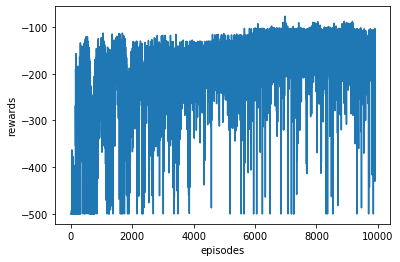

In [8]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel('episodes')
plt.ylabel('rewards')

In [14]:
avg_reward = []
index = []
sum_ = 0
for i in range(len(rewards)):
    if(i%100 == 0):
        avg_reward.append(sum_/100)
        index.append(i+1)
        sum_ = 0
    sum_+=rewards[i]
avg_reward.append(sum_/100)
index.append(i+1)

Text(0, 0.5, 'rewards')

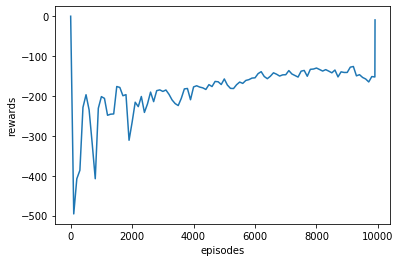

In [15]:
plt.plot(index,avg_reward)
plt.xlabel('episodes')
plt.ylabel('rewards')